In [45]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/dataset/datset/dataset/dataset/'  # prilagodi ako je drugačije
extract_to = '/content/dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
# --- Instalacija paketa ---
!pip install segmentation-models-pytorch --quiet
!pip install efficientnet-pytorch --quiet
!pip install albumentations --quiet

# --- Uvoz biblioteka ---
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
import torch.nn as nn

In [47]:
# === Dataset ===
class NightLightDataset(Dataset):
    def __init__(self, image_dir, transform=None, threshold=50):
        self.image_dir = image_dir
        self.files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform
        self.threshold = threshold

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = np.array(Image.open(img_path).convert("RGB"))
        gray = np.array(Image.open(img_path).convert("L"))
        mask = (gray > self.threshold).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = T.ToTensor()(image)
            mask = torch.tensor(mask).unsqueeze(0).float()

        return image, mask

In [48]:
# === Transformacije ===
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [49]:
# === Model factory ===
def get_model(model_name='unet', encoder_name='efficientnet-b0', pretrained=True):
    model_name = model_name.lower()
    if model_name == 'unet':
        return smp.Unet(encoder_name=encoder_name, encoder_weights='imagenet' if pretrained else None,
                        in_channels=3, classes=1, activation=None)
    elif model_name == 'fpn':
        return smp.FPN(encoder_name=encoder_name, encoder_weights='imagenet' if pretrained else None,
                       in_channels=3, classes=1, activation=None)
    elif model_name == 'deeplabv3':
        return smp.DeepLabV3(encoder_name=encoder_name, encoder_weights='imagenet' if pretrained else None,
                             in_channels=3, classes=1, activation=None)
    elif model_name == 'linknet':
        return smp.Linknet(encoder_name=encoder_name, encoder_weights='imagenet' if pretrained else None,
                           in_channels=3, classes=1, activation=None)
    elif model_name == 'pspnet':
        return smp.PSPNet(encoder_name=encoder_name, encoder_weights='imagenet' if pretrained else None,
                          in_channels=3, classes=1, activation=None)
    else:
        raise ValueError(f"Model '{model_name}' nije podržan!")


In [50]:
# === Metrike ===
def iou_score(preds, targets, threshold=0.5, smooth=1e-6):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) - intersection
    return ((intersection + smooth) / (union + smooth)).mean().item()

def dice_score(preds, targets, threshold=0.5, smooth=1e-6):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    return ((2 * intersection + smooth) / (preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) + smooth)).mean().item()

In [51]:
# === Trening i evaluacija ===
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        if masks.dim() == 3:
            masks = masks.unsqueeze(1)
        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, total_iou, total_dice = 0, 0, 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            if masks.dim() == 3:
                masks = masks.unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = torch.sigmoid(outputs)

            total_loss += loss.item()
            total_iou += iou_score(preds, masks)
            total_dice += dice_score(preds, masks)

    n = len(loader)
    return total_loss / n, total_iou / n, total_dice / n

In [52]:
# === Vizualizacija ===
def plot_samples(model, loader, device, n=3):
    model.eval()
    images, masks = next(iter(loader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float().cpu()

    plt.figure(figsize=(12, n * 4))
    for i in range(n):
        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))
        plt.title("Slika")
        plt.axis('off')

        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(masks[i][0], cmap='gray')
        plt.title("Maska")
        plt.axis('off')

        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(preds[i][0], cmap='gray')
        plt.title("Predikcija")
        plt.axis('off')
    plt.show()

In [53]:
# === Glavna logika ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Koristi se uređaj:", device)

IMAGE_DIR = path
dataset = NightLightDataset(IMAGE_DIR, transform=train_transform, threshold=50)

Koristi se uređaj: cpu


In [54]:
# Podjela na train/val
val_size = int(len(dataset) * 0.2)
train_size = len(dataset) - val_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
val_ds.dataset.transform = val_transform

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

In [71]:
# Model
model_name = 'unet'
encoder_name = 'efficientnet-b0'
model = get_model(model_name, encoder_name)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 3
best_val_loss = float('inf')

In [72]:
# Treniranje
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_iou, val_dice = eval_epoch(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val IoU: {val_iou:.4f} - Val Dice: {val_dice:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Model spremljen na epoch {epoch+1}")


Epoch 1/3 - Train Loss: 0.5543 - Val Loss: 0.5035 - Val IoU: 0.0198 - Val Dice: 0.0388
Model spremljen na epoch 1
Epoch 2/3 - Train Loss: 0.3255 - Val Loss: 0.3449 - Val IoU: 0.0974 - Val Dice: 0.1752
Model spremljen na epoch 2
Epoch 3/3 - Train Loss: 0.2362 - Val Loss: 0.2320 - Val IoU: 0.1621 - Val Dice: 0.2738
Model spremljen na epoch 3


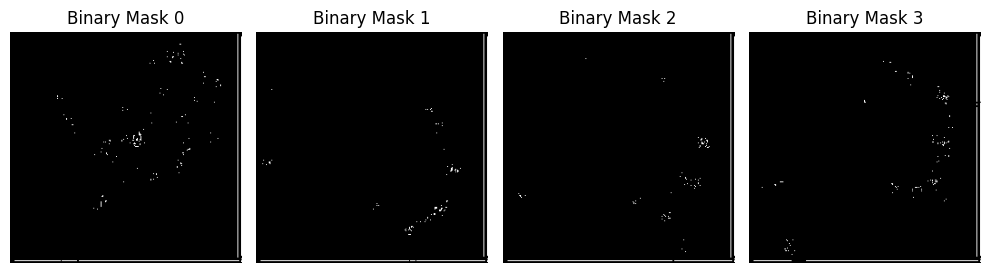

In [64]:
model.eval()
with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)
    predictions = torch.sigmoid(outputs).cpu()

# Sada možeš pozvati funkcije za prikaz
show_threshold_mask(predictions)


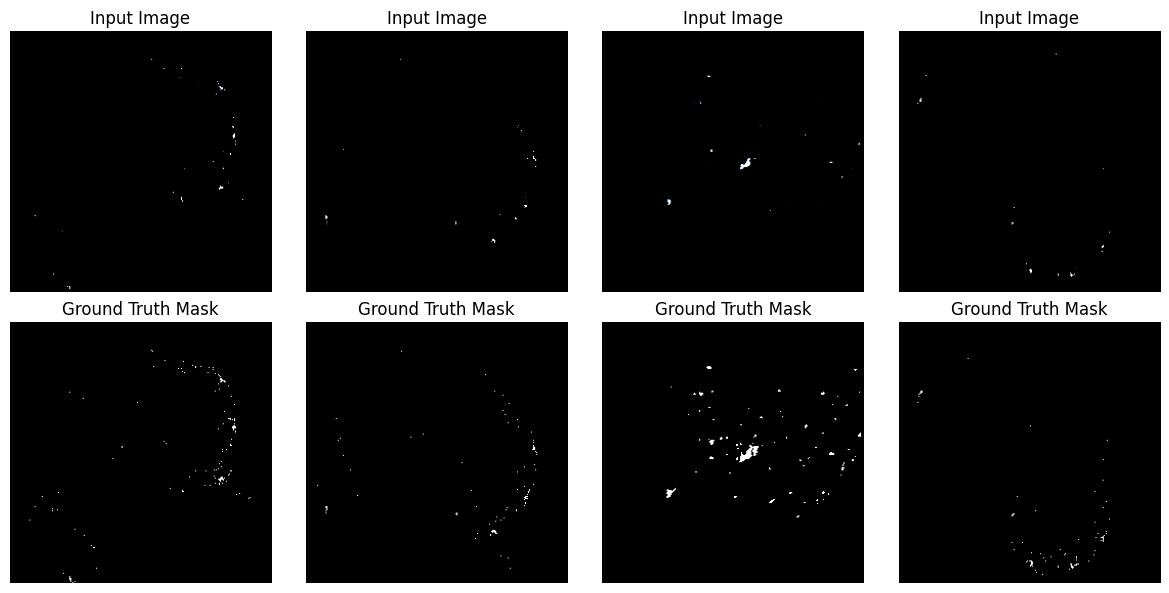

In [57]:
# Prikazuje ulazne slike i pripadajuće maske

def show_samples(images, masks, num_samples=4):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(masks[i], cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(images, masks)


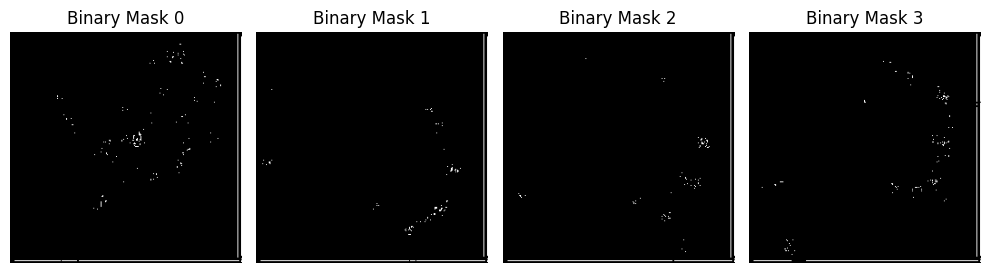

In [65]:
# Prikazuje binariziranu masku nakon thresholdanja predikcije.

def show_threshold_mask(predictions, threshold=0.5):
    binary_masks = (predictions > threshold).float()
    plt.figure(figsize=(10, 5))
    for i in range(min(4, len(binary_masks))):
        plt.subplot(1, 4, i + 1)
        plt.imshow(binary_masks[i][0], cmap='gray')
        plt.title(f"Binary Mask {i}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


show_threshold_mask(predictions)


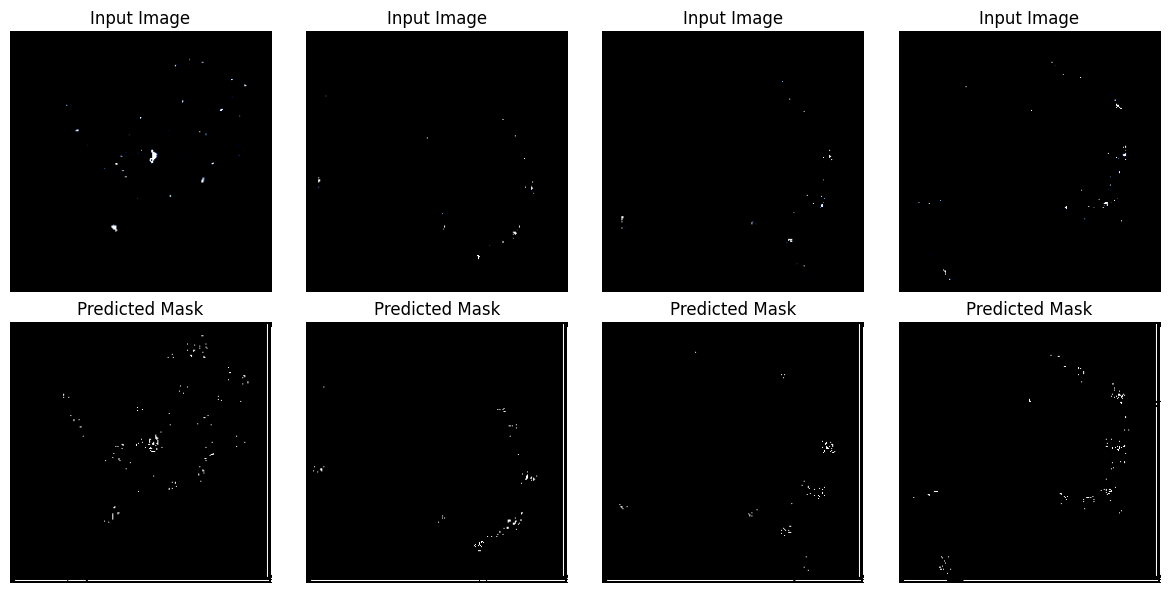

In [66]:
# Prikazuje originalne slike s predviđenim maskama.

def show_predictions(images, predictions, threshold=0.5):
    pred_masks = (predictions > threshold).float()
    plt.figure(figsize=(12, 6))
    for i in range(min(4, len(images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(2, 4, i + 5)
        plt.imshow(pred_masks[i][0], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_predictions(images, predictions)


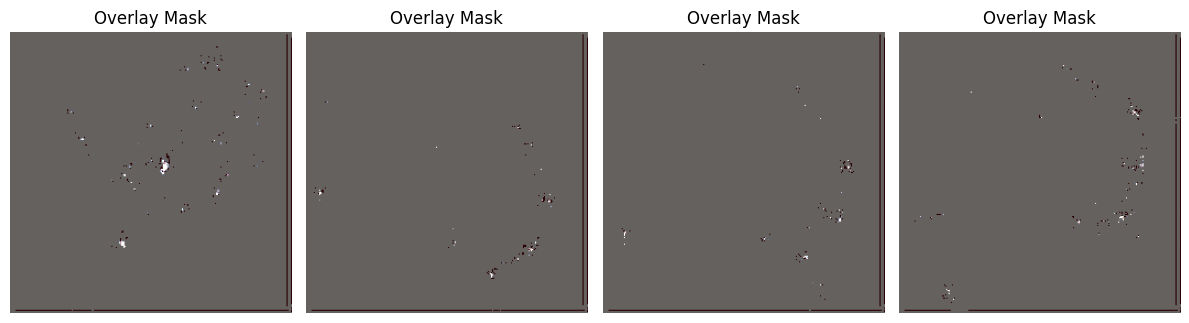

In [67]:
# Preklapa predviđenu masku preko originalne slike.

def show_overlay_mask(images, predictions, threshold=0.5):
    binary_masks = (predictions > threshold).float()
    plt.figure(figsize=(12, 6))
    for i in range(min(4, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        mask = binary_masks[i][0].numpy()

        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.imshow(mask, cmap='Reds', alpha=0.4)
        plt.title("Overlay Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_overlay_mask(images, predictions)


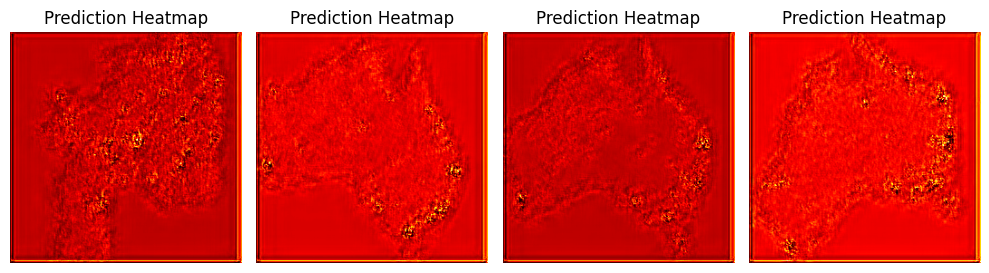

In [68]:
# Prikazuje heatmapu predikcija.

def show_prediction_heatmap(predictions):
    plt.figure(figsize=(10, 5))
    for i in range(min(4, len(predictions))):
        plt.subplot(1, 4, i + 1)
        plt.imshow(predictions[i][0].detach().cpu(), cmap='hot')
        plt.title("Prediction Heatmap")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_prediction_heatmap(predictions)


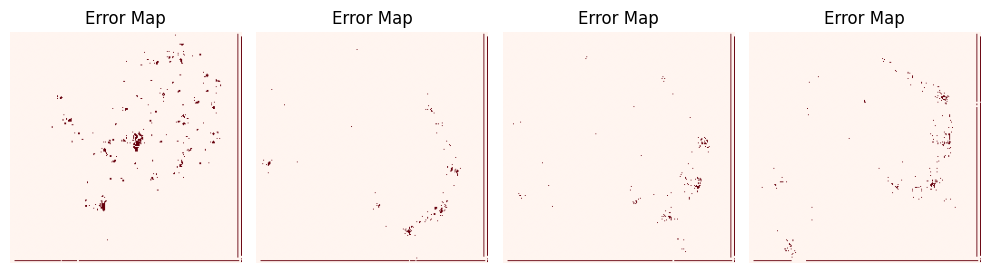

In [69]:
# Prikazuje mapu grešaka između predikcija i stvarnih maski.

def show_error_map(predictions, masks, threshold=0.5):
    pred_bin = (predictions > threshold).float()
    error_maps = torch.abs(pred_bin - masks.unsqueeze(1))
    plt.figure(figsize=(10, 5))
    for i in range(min(4, len(error_maps))):
        plt.subplot(1, 4, i + 1)
        plt.imshow(error_maps[i][0].cpu(), cmap='Reds')
        plt.title("Error Map")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_error_map(predictions, masks)
